# Gaussian Path Planning test

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

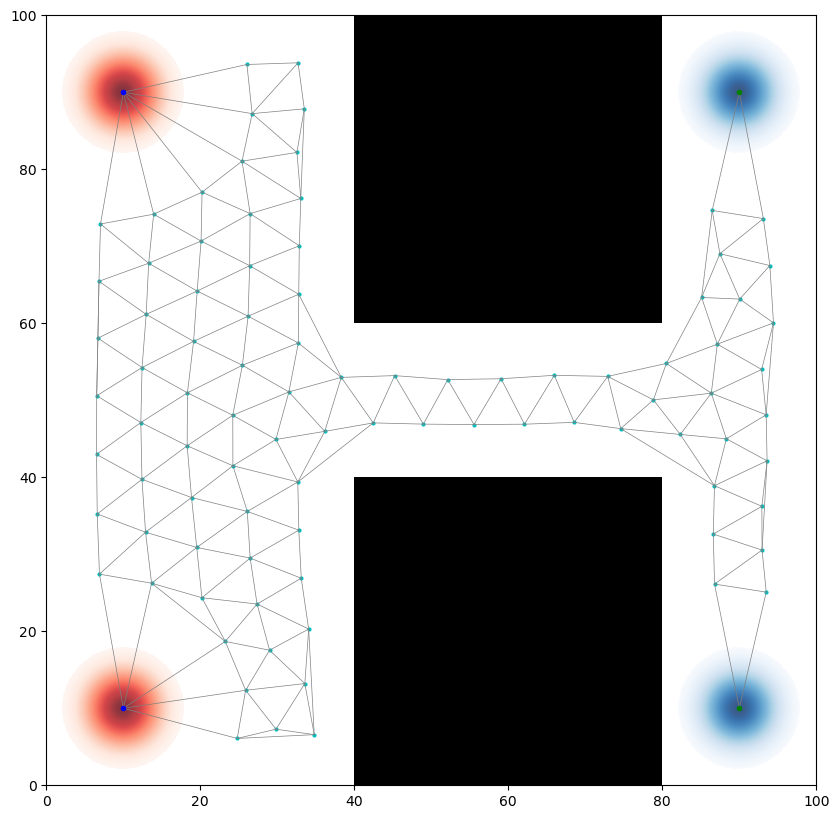

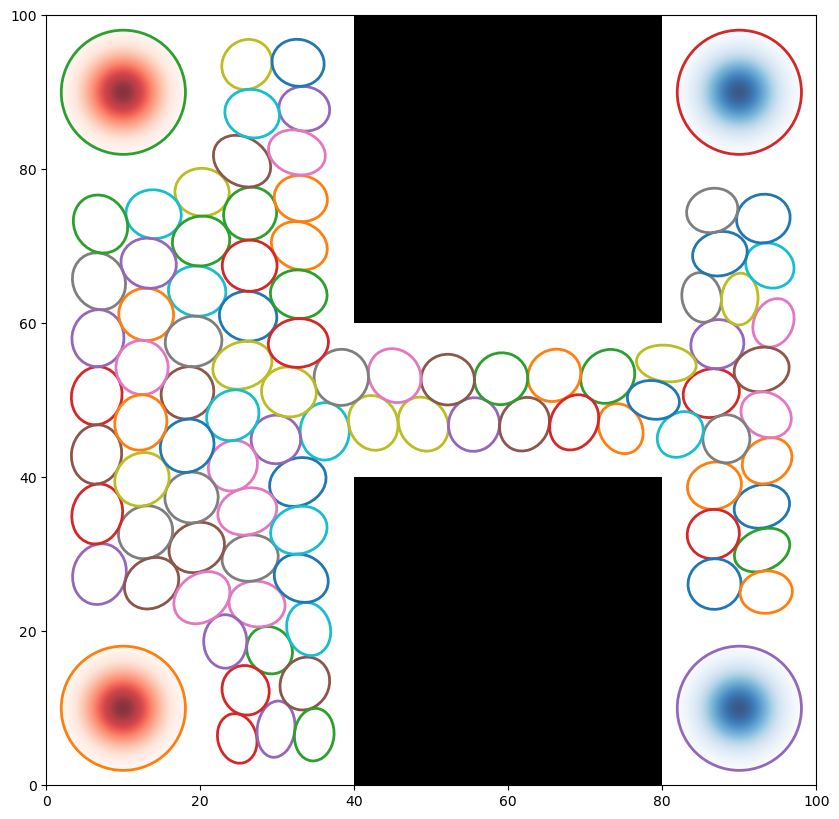

In [1]:
import pickle

from swarm_prm.solvers.utils.gaussian_prm import *
from swarm_prm.envs.roadmap import Roadmap, Obstacle 
from swarm_prm.envs.instance import Instance

roadmap = Roadmap(100, 100)
safety_radius = 2 
pos = np.array([50, 50])
obstacles  = [
    Obstacle(None, "POLYGON", [(40, 0), (40, 40), (80, 40), (80, 0)]),
    Obstacle(None, "POLYGON", [(40, 100), (40, 60), (80, 60), (80, 100)])
]
num_samples = 100 
for obs in obstacles:
    roadmap.add_obstacle(obs)
# fig, ax = roadmap.visualize()
start_mean = np.random.rand(2) * 100
goal_mean = np.random.rand(2) * 100

# Agent config
sampling_method = "GAUSSIAN_SAMPLING"
#sampling_method = "SWARMPRM_SAMPLING"
hex_radius = 4
TEST_CVAR = False


# Curated test instance
starts = np.array([[10, 10], [10, 90]])
goals = np.array([[90, 90], [90, 10]])

starts_weight = np.array([.8, .2])
goals_weight = np.array([.5, .5])

g_starts = [GaussianGraphNode(start, None, "UNIFORM", radius=10) for start in starts]
g_goals = [GaussianGraphNode(goal, None, "UNIFORM", radius=10) for goal in goals]

instance = Instance(roadmap, g_starts, g_goals, starts_weight, goals_weight)

gaussian_prm = GaussianPRM(instance, num_samples, safety_radius=safety_radius,
                           hex_radius=hex_radius)
gaussian_prm.sample_free_space(sampling_strategy="CVT")
gaussian_prm.load_instance()
gaussian_prm.build_roadmap(roadmap_method="TRIANGULATION", collision_check_method="CVAR", radius=15)
gaussian_prm.visualize_roadmap("test_map")
gaussian_prm.visualize_g_nodes("test_g_nodes")

with open("gaussian_prm.pkl", "wb") as f:
    pickle.dump(gaussian_prm, f)

In [2]:
from swarm_prm.solvers.macro.teg import TEGGraph

num_agent = 120
agent_radius = 1    
teg_graph= TEGGraph(gaussian_prm, agent_radius, num_agents=num_agent, max_timestep=500)
max_flow, flow_dict, timestep, teg, paths, residual_graph = teg_graph.get_earliest_timestep()
with open("flow_dict.pkl", "wb") as f:
    pickle.dump(flow_dict, f)


Time step:  14 Max Flow:  90
Time step:  15 Max Flow:  120


In [3]:
import pickle

with open("gaussian_prm.pkl", "rb") as f:
    gaussian_prm = pickle.load(f)

with open("flow_dict.pkl", "rb") as f:
    flow_dict = pickle.load(f)

macro_sol = gaussian_prm.get_macro_solution(flow_dict)
simple_paths, gaussian_paths = gaussian_prm.get_solution(flow_dict, timestep, num_agent)
with open("macro_sol.pkl", "wb") as f:
    pickle.dump(macro_sol, f)

In [4]:
print(len(simple_paths))

120


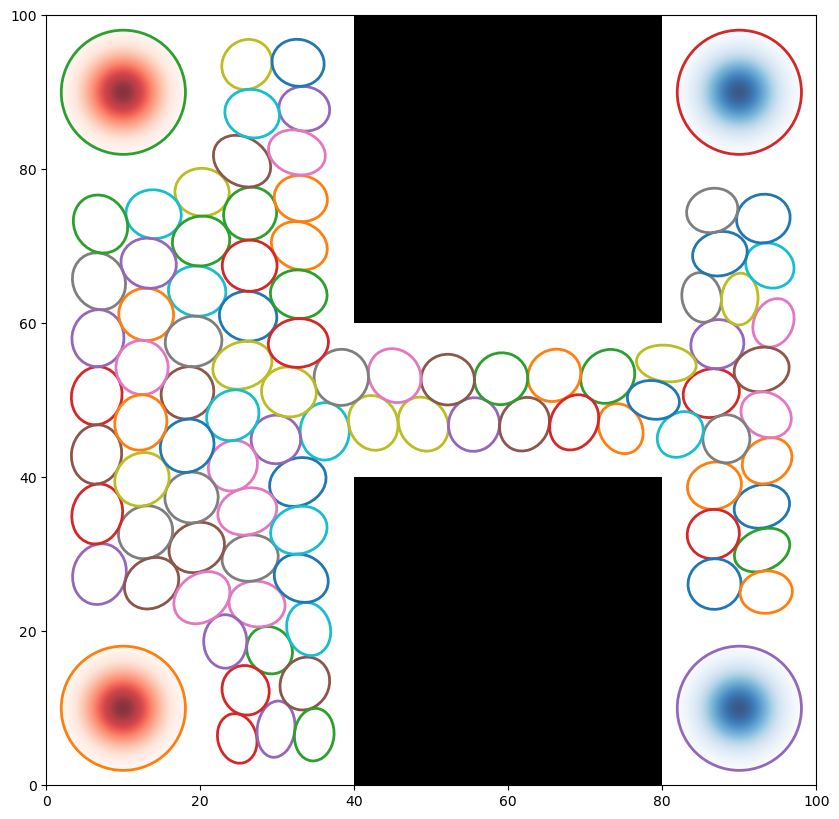

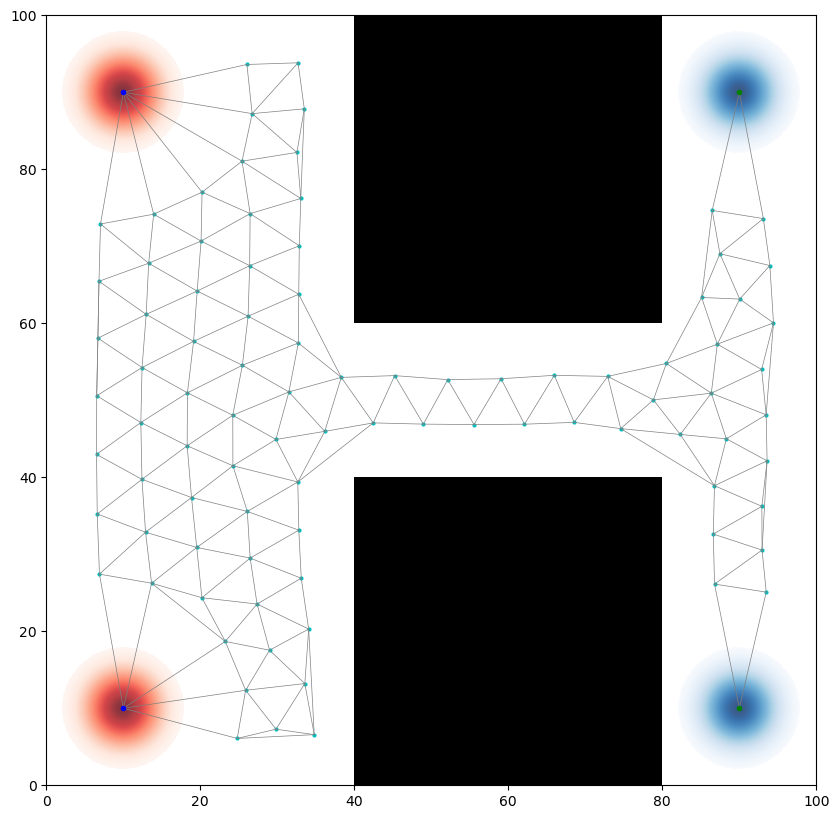

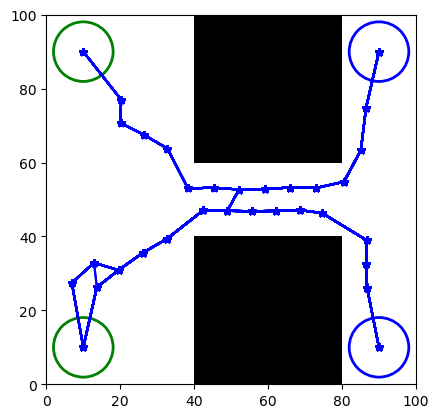

In [5]:
gaussian_prm.visualize_g_nodes()
gaussian_prm.visualize_roadmap()
fig, ax = instance.visualize()

# apf_solver.animate_solution(fig, ax)
for path in simple_paths:
    x_coords = [loc[0] for loc in path]
    y_coords = [loc[1] for loc in path]
    ax.plot(x_coords, y_coords, '-*', label='Path', color='blue')
# 

In [6]:
print(flow_dict)

defaultdict(<class 'dict'>, {('SS', None): {(91, 0): 96, (92, 0): 24}, (93, 14): {(93, 15): 48}, (94, 14): {(94, 15): 42}, (92, 0): {(18, 1): 24}, (91, 0): {(55, 1): 68, (44, 1): 28}, (44, 1): {(27, 2): 28}, (18, 1): {(72, 2): 24}, (55, 1): {(27, 2): 2, (25, 2): 66}, (27, 2): {(25, 3): 30}, (72, 2): {(73, 3): 24}, (25, 2): {(26, 3): 66}, (73, 3): {(82, 4): 24}, (25, 3): {(26, 4): 30}, (26, 3): {(10, 4): 66}, (82, 4): {(57, 5): 24}, (26, 4): {(10, 5): 30}, (10, 4): {(28, 5): 66}, (28, 5): {(8, 6): 66}, (57, 5): {(46, 6): 24}, (10, 5): {(28, 6): 30}, (8, 6): {(45, 7): 24, (14, 7): 42}, (46, 6): {(45, 7): 24}, (28, 6): {(8, 7): 30}, (45, 7): {(42, 8): 48}, (14, 7): {(15, 8): 42}, (8, 7): {(45, 8): 12, (14, 8): 18}, (45, 8): {(42, 9): 12}, (42, 8): {(41, 9): 48}, (15, 8): {(43, 9): 42}, (14, 8): {(15, 9): 18}, (41, 9): {(32, 10): 48}, (42, 9): {(41, 10): 12}, (15, 9): {(43, 10): 18}, (43, 9): {(31, 10): 42}, (41, 10): {(32, 11): 12}, (32, 10): {(38, 11): 48}, (31, 10): {(11, 11): 42}, (43,

## Gaussian Trajectory

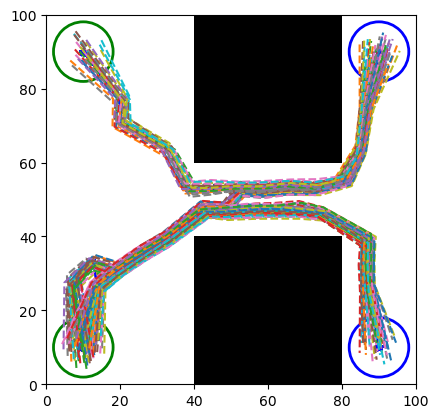

In [7]:
import pickle
from matplotlib import pyplot as plt
from swarm_prm.solvers.micro import GaussianTrajectorySolver

with open("gaussian_prm.pkl", "rb") as f:
    gaussian_prm = pickle.load(f)

with open("macro_sol.pkl", "rb") as f:
    macro_sol = pickle.load(f)

timestep = max(macro_sol.keys())

gt_solver = GaussianTrajectorySolver(gaussian_prm, macro_sol, timestep, num_agent, safety_gap=0.2)
gt_paths = gt_solver.solve()

fig, ax = instance.visualize()

for path in simple_paths:
    x_coords = [loc[0] for loc in path]
    y_coords = [loc[1] for loc in path]
    ax.plot(x_coords, y_coords, '-*', label='Path', color='blue')
# 
cmap = plt.get_cmap("tab10")

for i, path in enumerate(gt_paths):
    x_coords = [loc[0] for loc in path]
    y_coords = [loc[1] for loc in path]
    ax.plot(x_coords, y_coords, '--', label='Path', color=cmap(i%10))


In [8]:
# Add interpolations 

import numpy as np

def add_linear_interpolation_points(path, subdiv=5):
    """
    Insert linearly-interpolated positions between consecutive points.
    
    Parameters
    ----------
    path : array-like of shape (N, 2)
        The original list/array of N 2D points, e.g. [(x1,y1), (x2,y2), ...].
    subdiv : int
        Number of intervals to subdivide each segment. 
        For each original segment, we will add 'subdiv - 1' new interior points 
        (except that we skip duplicates at the shared boundary).

    Returns
    -------
    new_path : np.ndarray of shape (M, 2)
        The new path including the original points and the added interpolation points.
    """
    path = np.asarray(path)
    new_path = []

    # Iterate over pairs of consecutive points
    for i in range(len(path) - 1):
        start = path[i]
        end = path[i + 1]
        
        # Create subdiv+1 points in [start, end] using linspace for each dimension
        xs = np.linspace(start[0], end[0], subdiv + 1)
        ys = np.linspace(start[1], end[1], subdiv + 1)
        
        # Add each intermediate point except the very last one
        # to avoid duplicating the next segment's start
        for j in range(subdiv):
            new_path.append([xs[j], ys[j]])

    # Finally add the very last point of the last segment
    new_path.append(path[-1].tolist())
    
    return np.array(new_path)

interpolated_paths = []
for path in gt_paths:
    new_path = add_linear_interpolation_points(path, 50)
    interpolated_paths.append(new_path)


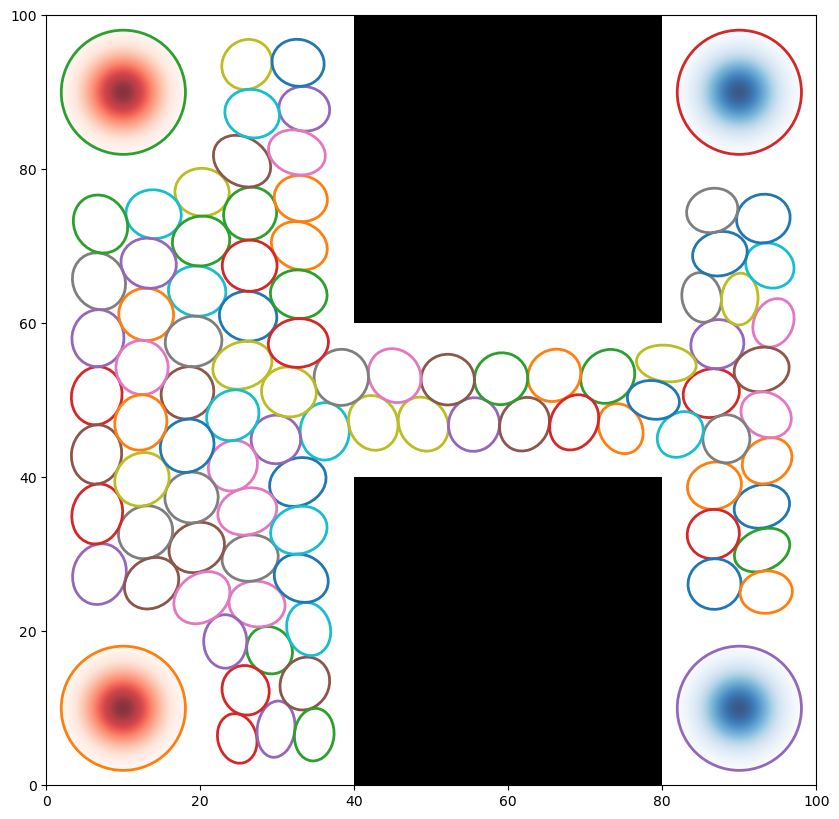

In [ ]:
def animate_solution(fig, ax, speed, paths):
    """
        Visualize solution trajectory provided instance
    """
    
    agents = []
    def init():
        for agent in agents:
            agent.remove()
        agents.clear()
        return []

    def update(frame):
        idx = frame * speed
        for agent in agents:
            agent.remove()
        agents.clear()
        cmap = plt.get_cmap("tab10")
        locs = [path[idx] for path in paths]
        for i, loc in enumerate(locs):
            agent = ax.add_patch(Circle(loc, radius=agent_radius, color=cmap(i%10)))
            agents.append(agent)
        return agents

    anim = FuncAnimation(fig, update, frames=len(paths[0])// speed , 
                         init_func=init, blit=True, interval=10)
    anim.save("apf_solution.gif", writer='pillow', fps=24)

# fig, ax = instance.visualize()
fig, ax = gaussian_prm.visualize_g_nodes()
animate_solution(fig, ax, 1, interpolated_paths)